In [26]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import joblib

In [28]:
df = pd.read_csv("train.csv")
df = df.drop("id", axis=1)

In [29]:
X = df.drop("NObeyesdad", axis=1)
y_raw = df["NObeyesdad"]

In [30]:
le = LabelEncoder()
y = le.fit_transform(y_raw)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [32]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [33]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=398,
        learning_rate=0.039,
        gamma=0.2,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_lambda=0.6,
        random_state=3361
    ))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC',
                                                   'MTRANS'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callback...
                               feature_types=None, feature_weights=None,
                               gamma=0.2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.039, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=398,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [34]:
y_pred = pipeline.predict(X_val)

print(classification_report(y_val, y_pred, target_names=le.classes_))
print("Accuracy: {} %".format(round(100 * accuracy_score(y_val, y_pred), 2)))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.94      0.94       505
      Normal_Weight       0.88      0.89      0.89       617
     Obesity_Type_I       0.89      0.90      0.90       582
    Obesity_Type_II       0.97      0.98      0.97       650
   Obesity_Type_III       1.00      1.00      1.00       809
 Overweight_Level_I       0.82      0.78      0.80       485
Overweight_Level_II       0.82      0.82      0.82       504

           accuracy                           0.91      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.91      0.91      0.91      4152

Accuracy: 91.14 %


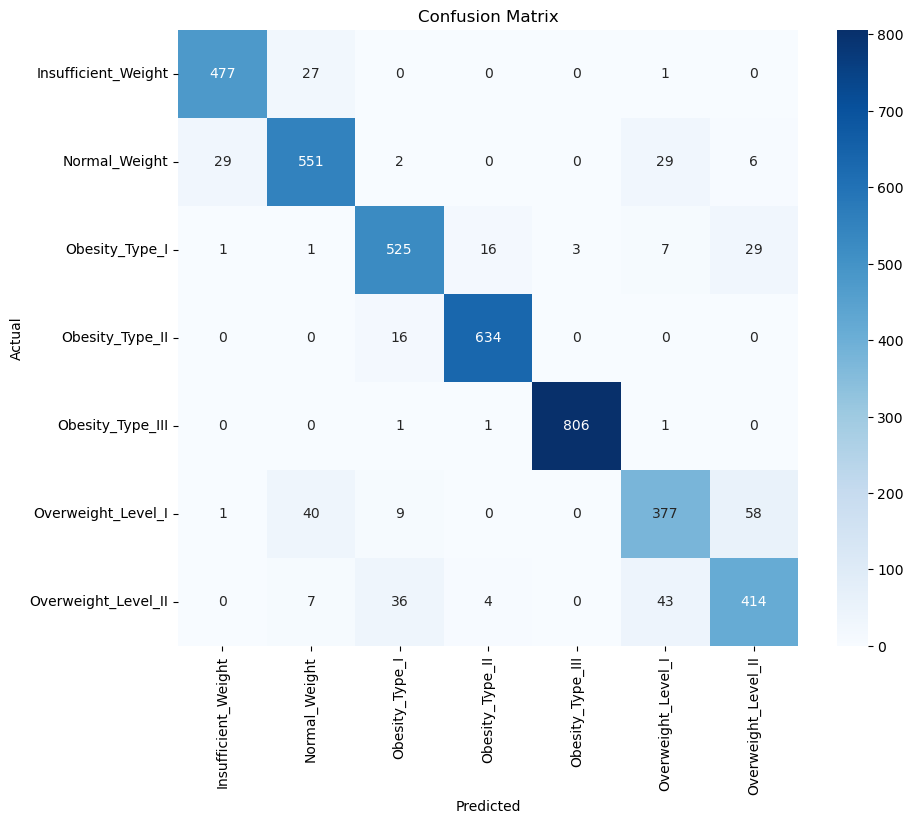

In [35]:
labels = le.classes_
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

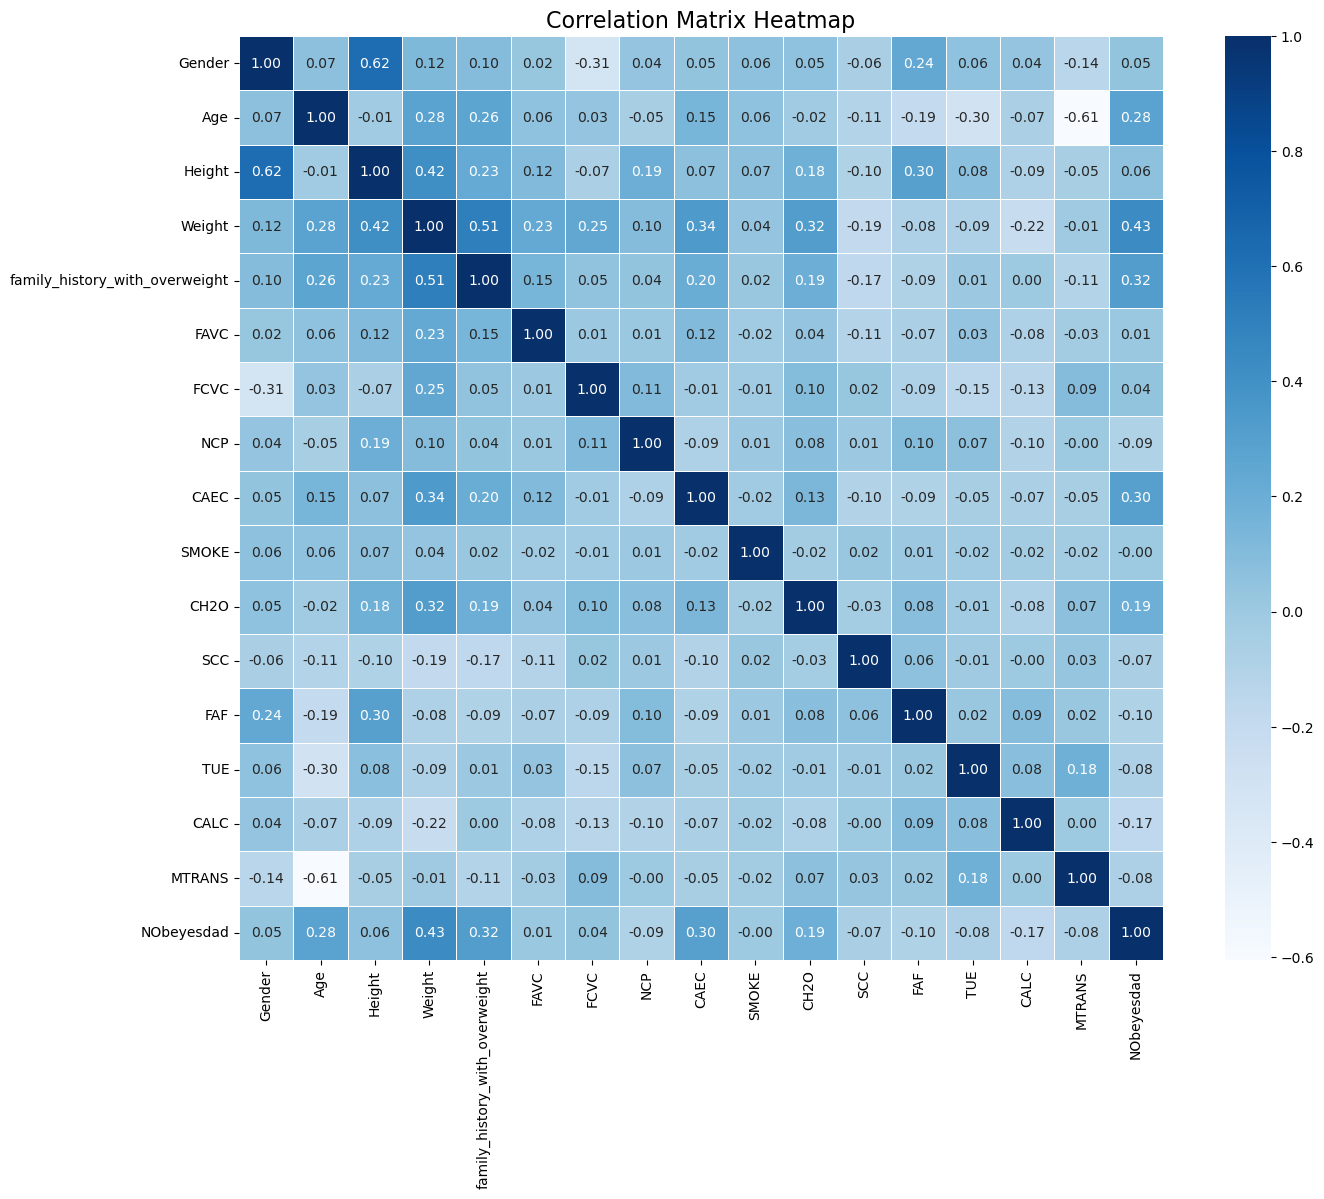

In [36]:
df_corr = df.copy()

for col in df_corr.select_dtypes(include="object").columns:
    df_corr[col] = df_corr[col].astype("category").cat.codes

df_corr["NObeyesdad"] = le.transform(df["NObeyesdad"])

corr_matrix = df_corr.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='Blues',
            linewidths=0.5,
            fmt=".2f",
            square=True)

plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv)

print("Cross-validation scores:", scores.round(4))
print("Mean:", round(scores.mean(), 4))
print("Std Dev:", round(scores.std(), 4))

In [ ]:
joblib.dump(pipeline, "obesity_pipeline.joblib")
joblib.dump(le, "label_encoder.joblib")  